In [1]:
# https://www.cs.rice.edu/~vo9/recognition/2016/notebooks/image_processing.html
    
import os
from PIL import Image
from scipy.fftpack import fft, fftshift, ifft
from scipy.fftpack import fftfreq
import scipy.io.wavfile as wavfile
import scipy
from scipy import signal
import librosa
import numpy as np
import matplotlib.pyplot as plt
import IPython.display as ipd
from IPython.display import Audio
from IPython import display
from matplotlib.ticker import ScalarFormatter
from matplotlib.ticker import EngFormatter

import soundfile as sf           
from scipy.signal import welch   
from scipy.io import wavfile
import scipy.signal as sps
import torch
import torchaudio
import torchaudio.functional as F
import torchaudio.transforms as T
from sampling import module_functions
import torch.nn as nn
import torchvision
from PIL import Image
import torchvision.transforms as transforms
import torch.nn.functional as Fu
from io import BytesIO
import IPython.display
import torchvision.transforms.functional as Fh
from torchvision.io import read_image
import cv2
import kornia
from kornia.color import rgb_to_grayscale, rgba_to_rgb
from kornia.color import rgb_to_grayscale, rgba_to_rgb
from kornia.color.gray import grayscale_to_rgb
from kornia.color.rgb import rgb_to_rgba
from kornia.core import Device, Tensor
from kornia.core.check import KORNIA_CHECK
from typing import Optional
from kornia.color.rgb import bgr_to_rgb
from kornia.core import Module, Tensor, concatenate
from kornia.core.check import KORNIA_CHECK_IS_TENSOR

%matplotlib inline

# Procesamiento básico de imágenes

In [2]:
_SAMPLE_DIR_IMG  = "image_data"
img_path = os.path.join(_SAMPLE_DIR_IMG, "anthropogenic_noise_on_marine_invertebrates.png")
os.makedirs(_SAMPLE_DIR_IMG, exist_ok=True)

## Imagen original en color RGB

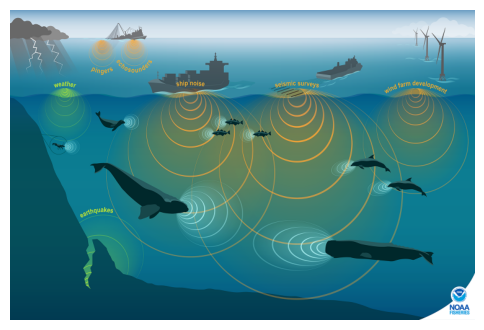

In [3]:
image = Image.open(img_path).convert('RGB')

plt.figure(figsize=[6, 6])
plt.imshow(image)
plt.axis('off');

In [4]:
to_tensor = transforms.ToTensor()
img_t = to_tensor(image)

In [5]:
img_t.shape[0]

3

> La imagen RGB está contenida en un tensor de tamaño: número canales $\times$ alto $\times$ ancho correspondiente a las dimensiones de la imagen. 

> Cada valor está entre 0 y 1.

In [6]:
print('Number of channels: ', img_t.shape[0])
print('Image height: ', img_t.shape[1])
print('Image width: ', img_t.shape[2])
print('Max value: ', torch.max(img_t))
print('Min value: ', torch.min(img_t))

Number of channels:  3
Image height:  500
Image width:  750
Max value:  tensor(1.)
Min value:  tensor(0.)


##  Canales R, G y B por separa de una imagen

In [7]:
r_image = img_t[0]
g_image = img_t[1]
b_image = img_t[2]

> Cada una de las siguientes imágenes es una imagen de uno de los canales:

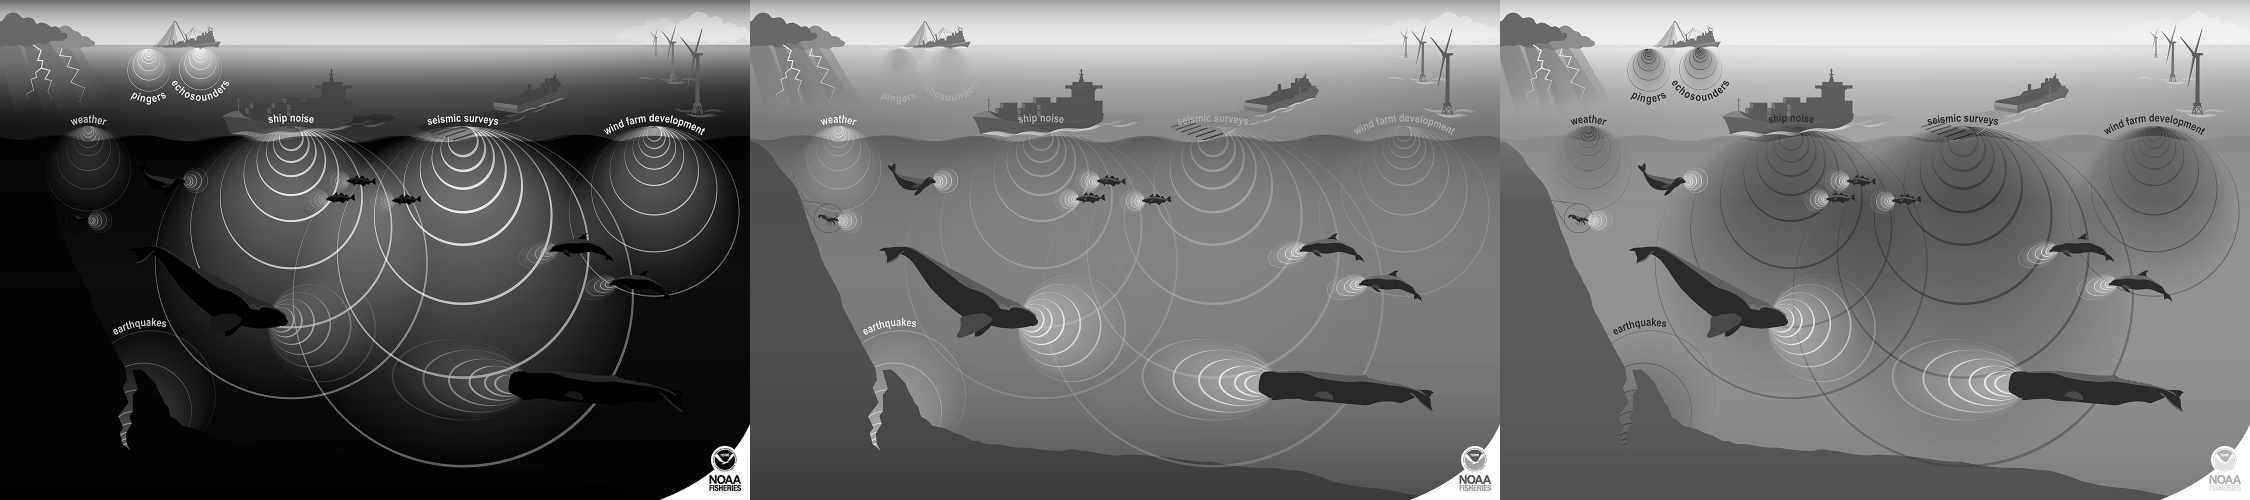

In [8]:
# width here (1), height (0).
module_functions.show_grayscale_image(torch.cat((r_image, g_image, b_image), 1))

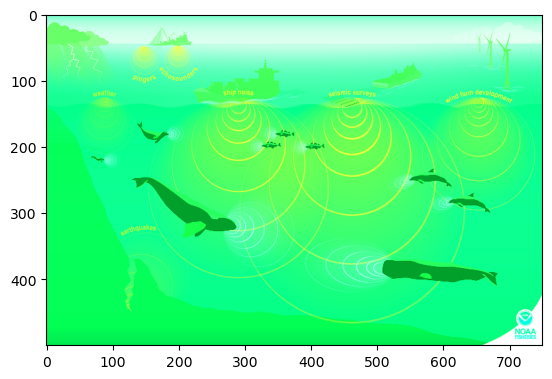

In [9]:
# We need to clone, otherwise both tensors would point to the same object, and we don't want to modify the
# original image as we want to keep working with it later. Always keep this in mind!
image_copy = img_t.clone()

# Multiply the green channel by two, clamp the values to the 0-1 range.
image_copy[1] = image_copy[1].mul(4.0).clamp(0.0, 1.0)

module_functions.plot_image(image_copy)

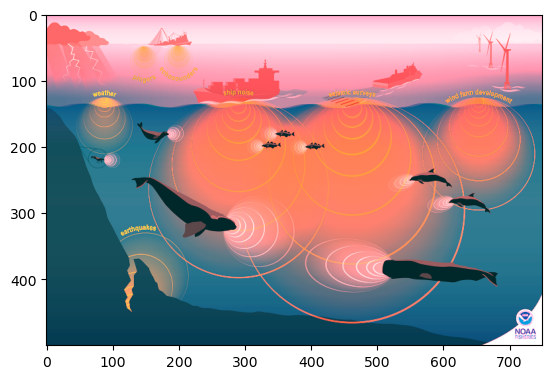

In [10]:
image_copy2 = img_t.clone()
image_copy2[0] = image_copy2[0].mul(4.0).clamp(0.0, 1.0)

module_functions.plot_image(image_copy2)

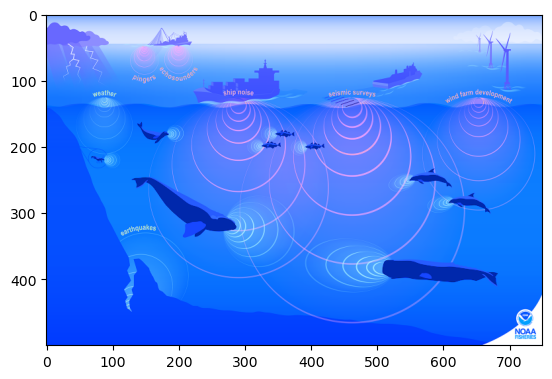

In [11]:
image_copy3 = img_t.clone()
image_copy3[2] = image_copy3[2].mul(4.0).clamp(0.0, 1.0)

module_functions.plot_image(image_copy3)

##  Corvertir imagen en color RGB en escala de grises

> Cada una de las tres imágenes de arriba es una imagen de un canal, que corresponde a uno de los canales RGB.

> Una forma es promediar los tres canales RGB. 

> Dividimos por 3, dado que cada canal tiene valores entre 0 y 1, queremos asegurarnos de que la imagen en escala de grises resultante también tenga valores entre 0 y 1.

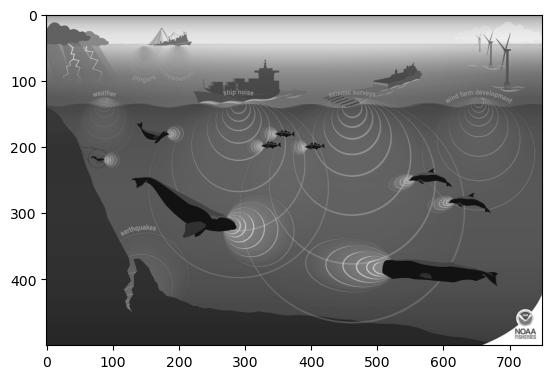

In [12]:
grayscale_image = (r_image + g_image + b_image).div(3.0)

module_functions.plot_grayscale_image(grayscale_image)

> Otra manera de convertir una imagen en color RGB, en una imagen en escala de grises, es usar un promedio ponderado. Por ejemplo:

In [13]:
gr_image = 0.2*r_image + 0.7*r_image + 0.07*r_image

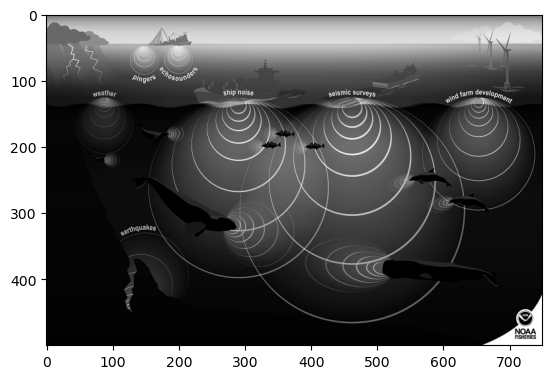

In [14]:
module_functions.plot_grayscale_image(gr_image)

> ¿Por qué estos se hace? Está inspirado en cómo los seres humanos perciben las imágenes. 

> No tenemos la misma sensibilidad para los tres canales. 

> Los coeficientes reflejan esto. Somos considerablemente menos sensibles al azul. Más sensibles al verde

> Aquí hay una exposición más detallada: [https://www.blueconemonochromacy.org/how-the-eye-functions/]

##  Otro espacio de color

> Además de las imágenes RGB, podemos representar imágenes como HSV.

> Cada canal HSV, corresponde a <span style="color:red">Tono</span>, <span style="color:red">Saturación</span> y <span style="color:red">Valor (~ luminosidad)</span>. 

> Su uso dependerá del análisis que se quiera realizar. Por ejemplo, si queremos centrarnos sólo en el tono y la saturación, pero no nos importa demasiado el valor. 

##  Crear un batch de imágenes

In [15]:
img_bgr: np.ndarray = cv2.imread(img_path, cv2.IMREAD_COLOR)

In [16]:
x_bgr: torch.Tensor = kornia.image_to_tensor(img_bgr, keepdim=False)

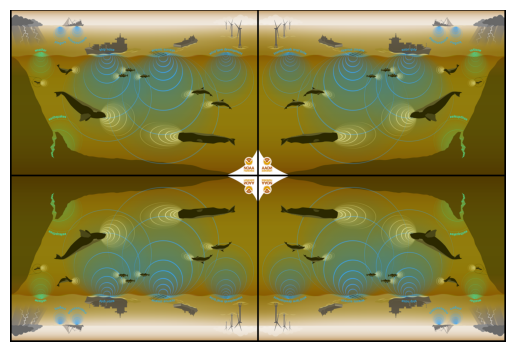

In [17]:
xb_bgr = torch.cat([x_bgr, module_functions.hflip(x_bgr), module_functions.vflip(x_bgr), module_functions.rot180(x_bgr)])
module_functions.imshow(xb_bgr)

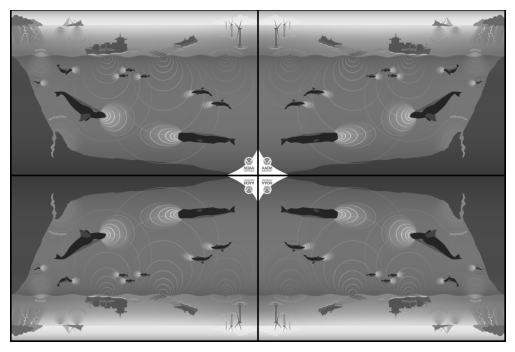

In [18]:
xb_gray = rgb_to_grayscale(xb_bgr.float() / 255.)
module_functions.imshow(xb_gray)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


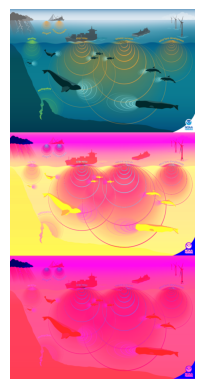

In [19]:
output1 = kornia.color.rgb_to_hsv(img_t, eps=0.00001)
output2 = kornia.color.rgb_to_hsv(img_t, eps=1)
module_functions.imshow(torch.cat([img_t, output1, output2], 1));